<h1>CS4618: Artificial Intelligence I</h1>
<h1>Regression</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>

$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

<h1>Regression</h1>
<ul>
    <li>We want to create programs that make <b>predictions</b>.</li>
    <li>Specifically in this part of the module we will consider predicting continuous <em>numeric values</em>.</li>
    <li>Prediction of numeric values is called <b>regression</b>:
        <ul>
            <li>Given a vector $\v{x}$ of feature values that describes some object, we predict a <b>target value</b>, which is numeric (real-valued).
            </li>
            <li>E.g.given a vector of feature values that describe a house, predict the selling price of the house.</li>
        </ul>
    </li>
    <li>(In everyday use, prediction is about the future; but we use the word more generally in AI.)</li>
</ul>

<h1>Notation</h1>
<ul>
    <li>We continue to use $\v{x}$ for an object.</li>
    <li>We will use $y$ for the target value.
    </li>
    <li>Actually, we will be even more precise:
        <ul>
            <li>We will use $y$ for the <em>actual</em> target value.</li>
            <li>We will use $\hat{y}$ for a <em>predicted</em> target value.</li>
        </ul>
    </li>
</ul>

<h1>Datasets of labeled examples</h1>
<ul>
    <li>We don't want to write a program to make these predictions.</li>
    <li>We want to learn how to make them.</li>
    <li>To learn how to make predictions, we need a dataset.
        <ul>
            <li>As before: $m$ examples, $n$ features</li>
        </ul>
        But we need a different kind of dataset: we need a dataset of <b>labeled examples</b>.
    </li>
    <li>A <b>labeled example</b> is a <em>pair</em>, comprising a vector of feature values and the target value
        $$\Tuple{\v{x}, y}$$
    </li>
    <li>So a <b>labeled dataset</b> looks like this: 
        $$\Set{\Tuple{\v{x}^{(1)}, y^{(1)}}, \Tuple{\v{x}^{(2)}, y^{(2)}}, \ldots, 
        \Tuple{\v{x}^{(m)}, y^{(m)}}}$$
        <ul>
             <li>E.g. the features are floor area, bedrooms and bathrooms; the target is the selling price
                (thousands of &euro;)
                 $$\Set{\Tuple{\cv{92.9\\3\\2}, 175},\,\, \Tuple{\cv{171.9\\4\\3}, 435},\,\, \Tuple{\cv{79\\3\\1}, 85}\cdots}$$
             </li>
         </ul>
     </li>
    <li>From a labeled dataset, we can construct a matrix $\v{X}$ <em>and</em> a vector $\v{y}$ as follows:
        $$\v{X} = \begin{bmatrix}
              \v{x}_1^{(1)} & \v{x}_2^{(1)} & \ldots & \v{x}_n^{(1)} \\
              \v{x}_1^{(2)} & \v{x}_2^{(2)} & \ldots & \v{x}_n^{(2)} \\
              \vdots        & \vdots        & \vdots & \vdots \\
              \v{x}_1^{(m)} & \v{x}_2^{(m)} & \ldots & \v{x}_n^{(m)} \\
              \end{bmatrix}\,\,\,\,\,
          \v{y} = \cv{y^{(1)}\\ y^{(2)}\\ \vdots\\ y^{(m)}}
        $$
        <ul>
            <li>In the matrix $\v{X}$, rows are examples, columns are features.</li>
            <li>The vector $\v{y}$ gives the corresponding target values.</li>
            <li>E.g
                $$\v{X} = 
                    \begin{bmatrix}
                        92.9 & 3 & 2 \\
                        171.9 & 4 & 3 \\
                        79 & 3 & 1
                    \end{bmatrix}\,\,\,\,\,
                  \v{y} = \cv{175\\ 435\\ 85}
                $$
            </li>
        </ul>
    </li>
</ul>

<ul>
    <li>Let's read our Cork property prices dataset into a pandas <code>DataFrame</code>.</li>
    <li>Then, we'll extract $\v{X}$ and $\v{y}$ and convert them to numpy arrays.
</ul>

In [ ]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("../datasets/dataset_corkA.csv")

# The features we want to select
features = ["flarea", "bdrms", "bthrms"]

# Extract these features and convert to numpy 2D array
X = df[features].values

# The target values, converted to a numpy 1D array
y = df["price"].values

<h1>Supervised Learning</h1>
<ul>
    <li>Learning from a <em>labeled dataset</em> is called <b>supervised learning</b>.</li>
    <li>The goal is to <b>generalize</b> from the labeled dataset so that we can predict target values
        when given the feature values of objects that were not in the labeled dataset (<b>unseen examples</b>).
    </li>
    <li>One way to categorize the algorithms for doing this is by how they generalize:
        <ul>
            <li><b>instance-based learning</b>; and</li>
            <li><b>model-based learning</b>.</li>
        </ul>
    </li>
</ul>

<h1>Instance-Based Learning</h1>
<ul>
    <li>Instance-based learners learn by heart: they simply store the examples in the labeled dataset.</li>
    <li>The way they generalize is using similarity (or distance): given an unseen example $\v{x}$, 
        they predict $\hat{y}$ from the $y$-values of examples in the dataset that are similar to $\v{x}$.
    </li>
    <li>Let's look at two concrete examples of this: <b>nearest-neighbour regression</b> and 
        $k$-<b>nearest-neighbours regression</b>.
    </li>
</ul>

<h2>Nearest-neighbour regression</h2>
<ul>
    <li>To predict the target value $\hat{y}$ for unseen example $\v{x}$,
        <ul>
            <li>we find the example $\Tuple{\v{x}', y'}$ in the labeled dataset whose distance from $\v{x}$ is 
                smallest; and
             </li>
             <li>we use $y'$ as our prediction.
             </li>
         </ul>
    </li>
    <li>We also refer to this as a <b>1-nearest-neighbour regressor</b> or
        just 1NN or kNN for $k=1$.
    </li>
    <li>We can easily implement this using code from the previous lecture.</li>
</ul>

In [ ]:
def euc(x, xprime):
    return np.sqrt(np.sum((x - xprime)**2))

def nn_regressor(x, X, y):
    # Find which example in X is the most similar to x
    index = np.argmin([euc(x, xprime) for xprime in X])
    # Return the corresponding target value from y
    return y[index]

In [ ]:
# Standardization of X
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# Standardization of our houses
our_houses = np.array([[126.0, 3, 1], [107.0, 2, 1]])
our_houses_scaled = scaler.transform(our_houses)


# Prediction
[nn_regressor(x_scaled, X_scaled, y) for x_scaled in our_houses_scaled]

<h2>k-nearest-neighbours regression</h2>
<ul>
    <li>The problems with 1NN is that it can be incorrectly influenced by noisy examples:
        <ul>
            <li>If there are examples in the labeled dataset where we have incorrectly recorded the feature values,
                then we may not find the best example from which to make our prediction.
            </li>
            <li>If there are examples in the labeled dataset where we have incorrectly recorded the target value,
                then these will result in incorrect predictions.
            </li>
        </ul>
    </li>
    <li>To reduce the influence of noisy examples, we use more than one neighbour:
        <ul>
            <li>we find $k$ examples whose distance from unseen example $\v{x}$ is smallest; and</li>
            <li>we use the mean of their $y$-values as our prediction.
            </li>
        </ul>
    </li>
    <li>We abbreviate the name of this to kNN, e.g. 3NN is where we use 3 nearest-neighbours.</li>
    <li>It too is easily implemented.</li>
</ul>

In [ ]:
def knn_regressor(x, X, y, k=3):
    # Find which k examples in X are the most similar to x
    indexes = np.argsort([euc(x, xprime) for xprime in X])[:k]
    # Return the mean of the corresponding target values from y
    return y[indexes].mean()

In [ ]:
# Prediction (with k=3, the default)
[knn_regressor(x_scaled, X_scaled, y) for x_scaled in our_houses_scaled]

<ul>
    <li>There are many variants of kNN.
        <ul>
            <li>A common one, for example, is to use a <b>weighted average</b> of the neighbour's target values.</li>
            <li>The weights could be the inverse of the distances so that more similar examples count for more.</li>
        </ul>
    </li>
    <li>We don't need to implement them for ourselves: scikit-learn has a class <code>KNeighborsRegressor</code>.
    </li>
</ul>

<h1>Model-Based Learning</h1>
<ul>
    <li>To get an intuition for what we mean by the word <b>model</b>, we'll imagine the following.</li>
    <li>We want to build a system that can predict the selling prices of houses in Cork.</li>
    <li>We don't know how to do it, so we ask Ann!
        <ul>
            <li>She's an auctioneer &mdash; an expert at predicting Cork city house prices.</li>
            <li>But we don't ask her to predict your house price or mine.</li>
            <li>We ask her for a <em>general</em> method for predicting Cork house prices.</li>
        </ul>
    </li>
    <li>She tells us that her rule-of-thumb is that prices start at 25k&euro; and increase by 1.5k&euro; for every 
        extra square metre of floor area:
        $$\hat{y} = 25 + 1.5\mathit{flarea}$$
        <ul>
            <li>So, she predicts your house (floor area of 126 square metres) will sell for 
                $\hat{y} = 25 + 1.5 \times 126 = 214$k&euro;
            </li>
        </ul>
    </li>
    <li>Ann has given us a <b>model</b>.
        <ul>
            <li>
                In very abstract terms, a model is an approximation of some part of reality that enables us to make 
                predictions about that reality.
            </li>
            <li>
                In very concrete terms for this module, a model is a formula (or function or procedure or set of 
                rules&hellip;) that expresses the relationship between an object's features and the thing that is
                being predicted (in regression, the target value).
            </li>
        </ul>
    </li>
    <li>(It so happens that Ann's is a <b>linear model</b> &mdash; see next lecture.)</li>
</ul>

<h2>Implementing and visualizing Ann's model</h2>

In [ ]:
# Ann's model
def h_ann(flarea):
    return 25 + 1.5 * flarea

In [ ]:
# Predicting the selling price of your house
h_ann(126)

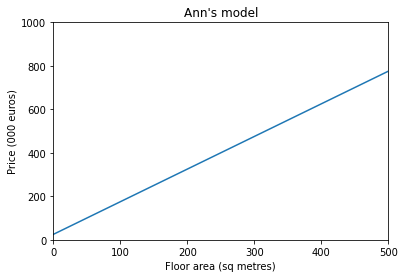

In [ ]:
# Plotting the predictions made by Ann's model
fig = plt.figure()
plt.title("Ann's model")
xvals = np.linspace(0, 500, 2)
plt.plot(xvals, h_ann(xvals))
plt.xlabel("Floor area (sq metres)")
plt.xlim(0, 500)
plt.ylabel("Price (000 euros)")
plt.ylim(0, 1000)
plt.show()

<ul>
    <li>Pre-Covid, I met this guy called Dev in a pub. He isn't a Cork auctioneer but he's really opinionated.</li>
    <li>He gave me a different model:
        $$\hat{y} = 20 + 50\mathit{bdrms} + 10\mathit{bdrms}^2$$
    </li>
    <li>(Dev's model is not a linear model &mdash; it is a non-linear model. In fact, it's a quadratic model.)</li>
</ul>

<h2>Implementing and visualizing Dev's model</h2>

In [ ]:
# Dev's model
def h_dev(bdrms):
    return 20 + 50 * bdrms + 10 * bdrms ** 2

In [ ]:
# Predicting the selling price of your house
h_dev(3)

In [ ]:
# Plotting the predictions made by Dev's model
fig = plt.figure()
plt.title("Dev's model")
xvals = np.linspace(0, 10, 10)
plt.plot(xvals, h_dev(xvals))
plt.xlabel("Bdrms")
plt.xlim(0, 10)
plt.ylabel("Price (000 euros)")
plt.ylim(0, 1500)
plt.show()

<h2>Building a model: learn from data</h2>
<ul>
    <li>Rather than ask an expert, we want to <b>learn</b> models like Ann's and Dev's from our labeled dataset.</li>
    <li>
        We would take some or all of the examples, call them the <b>training set</b>, and give them to a 
        learning algorithm.
    </li>
    <li>As best it can, the learning algorithm would find a model based on the labeled examples in the training set.
    </li>
</ul>

<h2>Learning from data</h2>
<figure>
    <img src="images/learning.png" />
</figure>

<h2>Terminology</h2>
<ul>
    <li>
        We will say that the algorithm <b>learns</b> a model.
    </li>
    <li>
        We could also say that we are <b>training</b> the algorithm on the data.
    <li>
        We could also say that the algorithm <b>fits</b> a model to the training set.
    </li>
    <li>
        We could also call it <b>function approximation</b>.
    </li>
</ul>

<h2>Model-based learning in scikit-learn</h2>
<ul>
    <li>So let's use scikit-learn to learn a linear model from our labeled dataset.</li>
    <li>The class for this is called <code>LinearRegression</code>.</li>
</ul>

In [ ]:
# Fit the model

linear_model = LinearRegression()

linear_model.fit(X, y)

In [ ]:
# Make a prediction
linear_model.predict(our_houses)

<ul>
    <li>As you case see, for the <code>LinearRegression</code> class, we don't need to scale the data (although 
        it wouldn't do any harm if we did).
    </li>
    <li>You might be wondering what linear model it actually learned. Is it the same as Ann's?
    </li>
</ul>

In [ ]:
linear_model.intercept_, linear_model.coef_

<ul>
    <li>So this is what it learned:
        $$\hat{y} = 38 + 2.5 \times \mathit{flarea} + -0.3 \times \mathit{bdrms} + 0.8 \times \mathit{bthrms}$$
    </li>
    <li>Very different from Ann's!</li>
</ul>

<ul>
    <li>scikit-learn has a nice API:
        <ul>
            <li>All classes for transforming data, e.g. scaling it, have methods called <code>fit</code>
                and <code>transform</code>:
                <ul>
                    <li><code>fit</code> computes anything that is needed to carry out the
                        transformation. For example, in the case of <code>StandardScaler</code>, it calculates
                        the mean and standard deviation.
                    </li>
                    <li><code>transform</code> performs the actual transformation. In the case of
                        <code>StandardScaler</code>, it subtracts the mean and divides by the standard deviation.
                    </li>
                </ul>
            </li>
            <li>All classes for making predictions have methods called <code>fit</code> and <code>predict</code>:
                <ul>
                    <li><code>fit</code> builds the model. 
                        <ul>
                            <li>For example, for <code>KNeighborsRegressor</code>, it chooses a data structure
                                for storing the labeld dataset.
                            </li>
                            <li>For <code>LinearRegression</code>, it learns the linear model from the labeled
                                dataset.
                            </li>
                        </ul>
                    </li>
                    <li><code>predict</code> uses the model to make predictions.
                        <ul>
                            <li>For example, for <code>KNeighborsRegressor</code>, it finds neighbours and
                                averages their $y$-values.
                            </li>
                            <li>For <code>LinearRegression</code>, it plugs values into the formula learned
                                by the <code>fit</code> method.
                            </li>
                        </ul>
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>We can see how neat it is by showing the code for the <code>KNeighborsRegressor</code>:
 </ul>

In [ ]:
# Fit the model

knn = KNeighborsRegressor(n_neighbors=3)

knn.fit(X_scaled, y)

In [ ]:
# Make a prediction
knn.predict(our_houses_scaled)

<ul>
    <li><strong>Don't copy any code from this notebook!</strong></li>
    <li>We don't normally call <code>fit/transform</code> or <code>fit/predict</code> ourselves. There 
        are functions that call them for us (e.g. <code>cross_val_score</code>).
    </li>
    <li>We don't normally learn the model from the entire dataset: we split it into a training set and a test set, 
        and we learn the model only from the training set.
    </li>
</ul>